# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [2]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
from sklearn.model_selection import train_test_split
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

from Data.load_data import get_energy_data
from helper_functions import create_error_metrics

## Model Selection

### Prophet
> Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

> Prophet is open source software released by Facebook's Core Data Science team. It is available for download on CRAN and PyPI.

https://facebook.github.io/prophet/

A model description can be found in this [paper](https://peerj.com/preprints/3190/).

Our data consists of different types of seasonality (seasons, weekend/working day and day/night) such that it should work very well with prophet.

Assumptions:
- We assume that seasonality is additive, i.e. seasonality does not grow with the trend: [docs multiplicative_seasonality](https://facebook.github.io/prophet/docs/multiplicative_seasonality.html)
- We start with Prophet's default fitting of saisonalities (yearly, weekly, daily): [docs custom seasonalities](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#specifying-custom-seasonalities)
- We use the default holidays for Germany from Prophet
- We ignore temperature in the first step as adding an additional regressor to the prophet model requires the regressor to be known in the past and also the future. This means this data comes from another source (could also be predicted values from another model): [docs additional regressors](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#additional-regressors)


## Load data

In [3]:
def create_dummy_variables(prefix: str, df_total_temp: pd.DataFrame, df_temp: pd.DataFrame) -> pd.DataFrame:
    df_dummies = pd.get_dummies(df_temp, prefix=prefix, drop_first=True)
    df_dummies.index = df_total_temp.index
    return df_dummies

In [4]:
# Load the dataset
df = get_energy_data()

df = pd.concat([
    df,
    create_dummy_variables("hour", df, df.index.hour),
    # create_dummy_variables("dayofweek", df, df.index.dayofweek),
    create_dummy_variables("month", df, df.index.month),
    create_dummy_variables("isweekend", df, df.index.weekday // 5),
], axis=1)

df_prophet = pd.DataFrame()
df_prophet['ds'] = list(map(lambda x: x.replace(tzinfo=None), df.index))
df_prophet['y'] = df['Load'].reset_index(inplace=False)['Load']

for col in df.columns:
    if (col != 'Temperature') & (col != 'Load'):
        df_prophet[col] = df[col].reset_index(inplace=False)[col]

# Split the dataset
df_train_prophet, df_test_prophet = train_test_split(df_prophet, test_size=0.2, shuffle=False)

In [5]:
# Add additional holidays
# Fronleichnam: 15.06.2017, 31.05.2018, 20.6.2019
# Allerheiligen: 01.11.XXXX
additional_holidays_no_window = pd.DataFrame({
    'holiday': 'additional_german_holidays',
    'ds': pd.to_datetime([
        '2017-12-31', '2018-12-31', '2019-12-31',
        '2017-11-01', '2018-11-01', '2019-11-01',
        '2017-06-15', '2018-05-31', '2019-06-20',
    ]),
    'lower_window': 0,
    'upper_window': 0,
})

# Make week between Christmas and new year a special week
additional_holidays_upper_window = pd.DataFrame({
    'holiday': 'additional_german_holidays',
    'ds': pd.to_datetime([
        '2017-12-24', '2018-12-24', '2019-12-24',
    ]),
    'lower_window': -1,
    'upper_window': 7,
})

holidays = pd.concat([additional_holidays_no_window, additional_holidays_upper_window])

## Hyperparameter Tuning

The hyperparameter tuning is done by varying the changepoint_prior_scale as well as the seasonality_prior_scale.

The changepoint_prior_scale determines the trend flexibility. The default value is 0.05. The documentation recommends to use a range of 0.001 to 0.5 [source](https://facebook.github.io/prophet/docs/diagnostics.html)

The seasonality_prior_scale determines the flexibility of the seasonality. The default value is 10 which means there is no regularization. A recommended range of values is between 0.01 and 10.

In [6]:
changepoint_prior_scale = [0.001, 0.01, 0.1, 0.5]
seasonality_prior_scale = [0.01, 0.1, 1.0, 10.0]

df_errors = pd.DataFrame(
    {'changepoint': [], 'seasonality': [], 'MAE': [], 'MSE': [], 'RMSE': [], 'MAPE %': [], 'R2 %': []})

for changepoint in changepoint_prior_scale:
    for seasonality in seasonality_prior_scale:
        
        m = Prophet(
            changepoint_prior_scale=changepoint,
            seasonality_prior_scale=seasonality,
            holidays=holidays
        )
        for col in df.columns:
            if (col != 'Temperature') & (col != 'Load'):
                m.add_regressor(col)
        m.fit(df_train_prophet)

        future = m.make_future_dataframe(periods=df_test_prophet.shape[0], freq='H')
        
        for col in df.columns:
            if (col != 'Temperature') & (col != 'Load'):
                future[col] = df[col].reset_index(inplace=False)[col]
        
        forecast = m.predict(future)

        errors = create_error_metrics(df_test_prophet['y'], forecast['yhat'].iloc[df_train_prophet.shape[0]:])
        errors['changepoint'] = [changepoint]
        errors['seasonality'] = [seasonality]

        df_errors = pd.concat([df_errors, errors])

print(df_errors)

08:05:57 - cmdstanpy - INFO - Chain [1] start processing
08:06:03 - cmdstanpy - INFO - Chain [1] done processing
08:06:11 - cmdstanpy - INFO - Chain [1] start processing
08:06:15 - cmdstanpy - INFO - Chain [1] done processing
08:06:23 - cmdstanpy - INFO - Chain [1] start processing
08:06:28 - cmdstanpy - INFO - Chain [1] done processing
08:06:36 - cmdstanpy - INFO - Chain [1] start processing
08:06:40 - cmdstanpy - INFO - Chain [1] done processing
08:06:49 - cmdstanpy - INFO - Chain [1] start processing
08:06:59 - cmdstanpy - INFO - Chain [1] done processing
08:07:07 - cmdstanpy - INFO - Chain [1] start processing
08:07:15 - cmdstanpy - INFO - Chain [1] done processing
08:07:23 - cmdstanpy - INFO - Chain [1] start processing
08:07:28 - cmdstanpy - INFO - Chain [1] done processing
08:07:36 - cmdstanpy - INFO - Chain [1] start processing
08:07:43 - cmdstanpy - INFO - Chain [1] done processing
08:07:51 - cmdstanpy - INFO - Chain [1] start processing
08:08:10 - cmdstanpy - INFO - Chain [1]

   changepoint  seasonality       MAE           MSE      RMSE  MAPE %    R2 %
0        0.001         0.01  10817.34  1.976211e+08  14057.78    5.14   86.95
0        0.001         0.10  10850.32  1.989113e+08  14103.59    5.15   86.86
0        0.001         1.00  10819.22  1.978724e+08  14066.71    5.14   86.93
0        0.001        10.00  10830.60  1.981989e+08  14078.31    5.14   86.91
0        0.010         0.01  10844.90  2.020937e+08  14215.97    5.22   86.65
0        0.010         0.10  10965.54  2.077070e+08  14412.04    5.29   86.28
0        0.010         1.00  10987.20  2.085743e+08  14442.10    5.31   86.22
0        0.010        10.00  10982.73  2.084149e+08  14436.58    5.30   86.23
0        0.100         0.01  20914.81  6.089814e+08  24677.55   10.00   59.78
0        0.100         0.10  33446.07  1.435644e+09  37889.89   15.66    5.18
0        0.100         1.00  34001.41  1.482771e+09  38506.76   15.91    2.07
0        0.100        10.00  33928.29  1.475070e+09  38406.63   

## Implementation


In [7]:
prophet2 = Prophet(changepoint_prior_scale=0.001, seasonality_prior_scale=0.01, holidays=holidays,
                   scaling='minmax')  # making the trend less flexible or flat with growth='flat'

for col in df.columns:
    if (col != 'Temperature') & (col != 'Load'):
        prophet2.add_regressor(col)

prophet2.add_country_holidays(country_name='DE')
prophet2.fit(df_train_prophet)

future2 = prophet2.make_future_dataframe(periods=df_test_prophet.shape[0], freq='H')

for col in df.columns:
    if (col != 'Temperature') & (col != 'Load'):
        future2[col] = df[col].reset_index(inplace=False)[col]
forecast2 = prophet2.predict(future2)

08:11:49 - cmdstanpy - INFO - Chain [1] start processing
08:11:55 - cmdstanpy - INFO - Chain [1] done processing


## Graphics

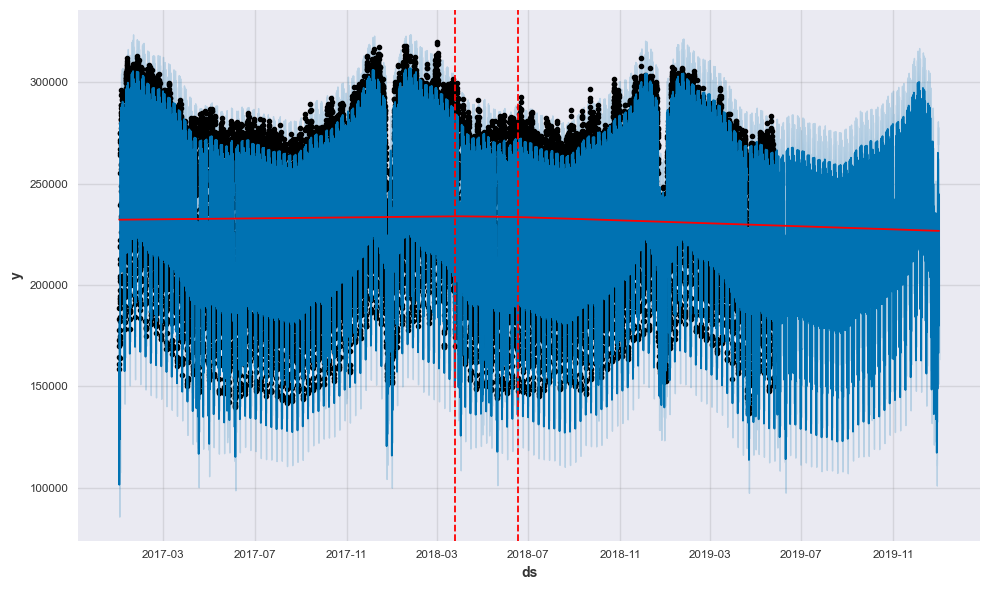

In [8]:
fig1 = prophet2.plot(forecast2)
a = add_changepoints_to_plot(fig1.gca(), prophet2, forecast2)

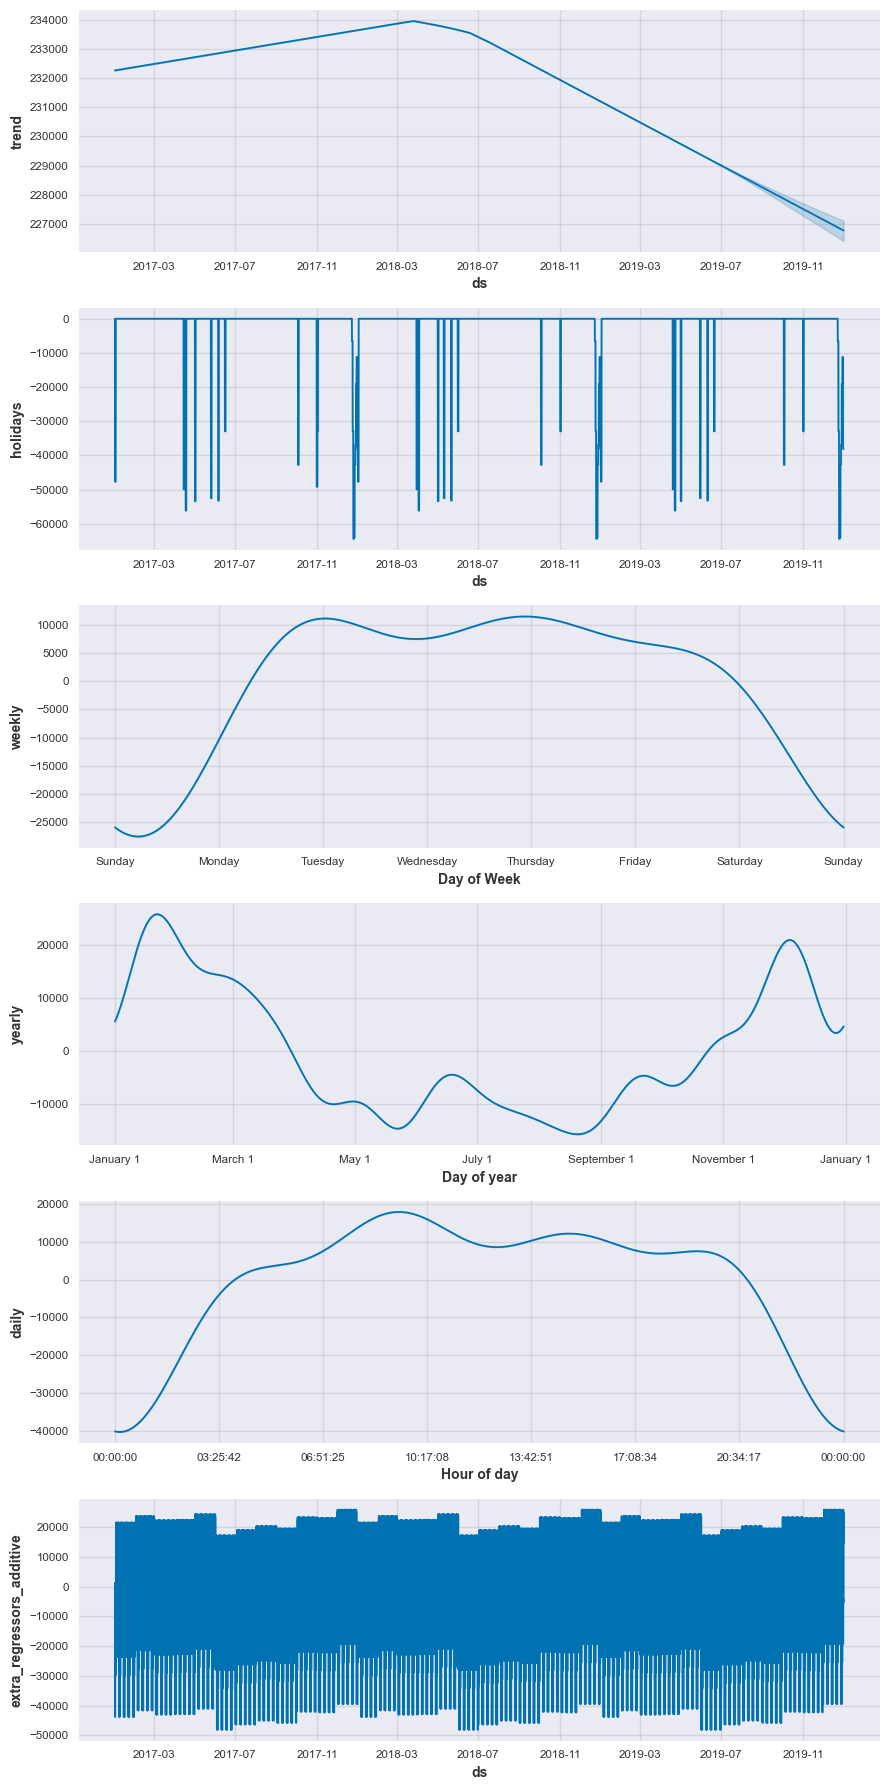

In [9]:
fig2 = prophet2.plot_components(forecast2)

<Axes: xlabel='ds'>

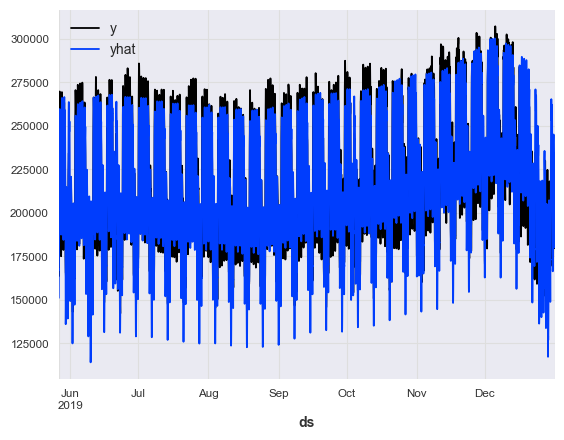

In [10]:
df_pred_prophet2 = pd.DataFrame()
df_pred_prophet2['y'] = df_test_prophet['y']
df_pred_prophet2['yhat'] = forecast2['yhat'].iloc[int(df_train_prophet.shape[0]):]
df_pred_prophet2.index = df_test_prophet['ds']
df_pred_prophet2[['y', 'yhat']].plot()

<Axes: xlabel='ds'>

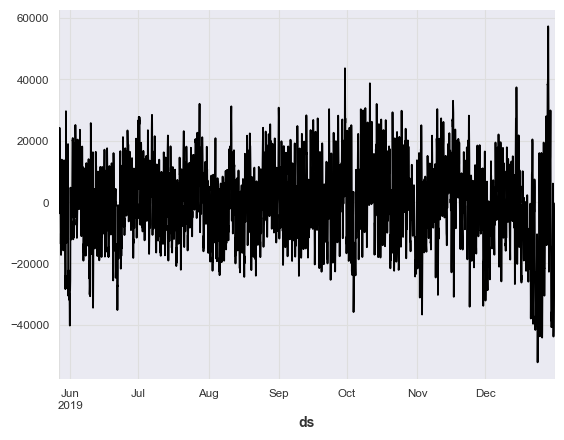

In [11]:
df_pred_prophet2['residuals'] = df_pred_prophet2['y'] - df_pred_prophet2['yhat']
df_pred_prophet2['residuals'].plot()

<Axes: >

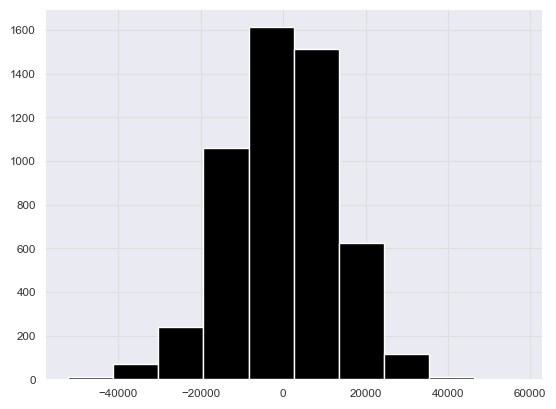

In [12]:
df_pred_prophet2['residuals'].hist()

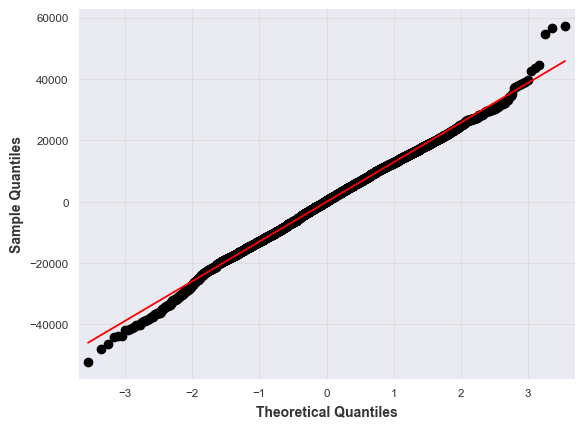

In [13]:
sm.qqplot(df_pred_prophet2['residuals'], line='s')
plt.show()

In [14]:
df_pred_prophet2['residuals']

ds
2019-05-26 23:00:00    16331.605347
2019-05-27 00:00:00    -3652.314046
2019-05-27 01:00:00    -3583.546312
2019-05-27 02:00:00    -1494.645959
2019-05-27 03:00:00     4502.390141
                           ...     
2019-12-31 18:00:00   -20714.975344
2019-12-31 19:00:00   -21513.652905
2019-12-31 20:00:00   -17206.828923
2019-12-31 21:00:00    -6475.681731
2019-12-31 22:00:00     -437.428902
Name: residuals, Length: 5256, dtype: float64

## Evaluation Metrics

In [17]:
create_error_metrics(df_test_prophet['y'], forecast2['yhat'].iloc[df_train_prophet.shape[0]:df_train_prophet.shape[0]+df_test_prophet.shape[0]])

,MAE,MSE,RMSE,MAPE %,R2 %
0,10296.36,1.667548e+08,12913.36,4.9,88.99


In [15]:
create_error_metrics(df_test_prophet['y'][0:24*7+1], forecast2['yhat'].iloc[df_train_prophet.shape[0]:df_train_prophet.shape[0]+24*7+1])

,MAE,MSE,RMSE,MAPE %,R2 %
0,12891.63,2.572657e+08,16039.5,6.59,78.34
